# EEG Pre-Processing Template

In [1]:
# Load dependencies
import pandas as pd
import numpy as np
import mne
import pyprep

## Load and prepare the recording file

In [2]:
# Load data from .txt file
# TODO
# Convert data into pandas DataFrame with electrode channels as columns
# TODO

# Set correct channel names
# You could use this if there are no other columns (the order of the elec names is correct): 
eeg_list = ['time', 'L1', 'L2', 'L3', 'L4', 'L7', 'L8', 'L9', 'L10', 'R1', 'R2', 'R3', 'R5', 'R7', 'R8', 'R9', 'R10']
# TODO

In [20]:
# from pathlib import Path
# import pandas

# def _reader(fname):
#     return pandas.read_csv(fname, sep=',', header=[0])

# folder = Path("eeg_data")
# df = pandas.concat([
#     _reader(txt)
#     for txt in folder.glob("*.txt")
# ])
# df
df = pd.read_csv('eeg_data/OpenBCI-RAW-2021-12-20_12-39-23_edited.txt',header=[0],sep=',')

In [22]:
df.drop('Sample Index', axis=1)

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,EXG Channel 9,...,Other.3,Other.4,Other.5,Other.6,Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Other.7,Timestamp (Formatted)
0,-6327.845911,3527.842883,12170.323690,-6548.234111,-9726.562765,-3687.724911,15574.807295,-6894.484984,1683.287523,11801.274038,...,120.0,8.0,126.5,40.0,0.0,0.0,0.0,1.640000e+09,0.0,2021-12-20 12:39:23.863
1,-6343.805056,3510.564984,12143.211024,-6566.651948,-9742.544263,-3708.109702,15554.064876,-6912.545194,3371.380671,23602.503372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640000e+09,0.0,2021-12-20 12:39:23.870
2,-6333.791475,3523.752513,12151.548225,-6560.773439,-9735.972850,-3699.705446,15565.330156,-6901.257563,3350.213569,23626.397386,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640000e+09,0.0,2021-12-20 12:39:23.875
3,-6330.304602,3522.947851,12151.995260,-6556.683070,-9734.519986,-3700.241888,15561.932690,-6902.844537,3361.098869,23624.855116,...,116.0,16.0,126.0,16.0,0.0,0.0,0.0,1.640000e+09,0.0,2021-12-20 12:39:23.882
4,-6323.800245,3534.928386,12159.058411,-6552.458591,-9724.595812,-3685.802661,15573.645004,-6894.775557,3361.612959,23606.616093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640000e+09,0.0,2021-12-20 12:39:23.889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202920,-5188.242219,695.854508,13252.975136,-7057.675070,-11652.701992,-3674.559733,10946.655088,-8564.182647,4405.662943,24955.298001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:06:24.410
202921,-5136.632042,725.179997,13238.155930,-7077.746937,-11680.731080,-3702.164138,10902.711559,-8585.662673,4439.235263,24970.027801,...,112.5,72.0,122.5,0.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:06:24.416
202922,-5148.858446,717.893328,13278.500829,-7050.634271,-11654.713649,-3685.132108,10916.346123,-8581.035862,4434.563748,24957.779045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:06:24.432
202923,-5152.904111,709.511424,13243.900328,-7064.760573,-11657.284100,-3679.119489,10933.601670,-8570.418783,4445.426696,24960.461254,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640002e+09,0.0,2021-12-20 13:06:24.439


In [23]:
df.columns

Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' EXG Channel 8', ' EXG Channel 9', ' EXG Channel 10',
       ' EXG Channel 11', ' EXG Channel 12', ' EXG Channel 13',
       ' EXG Channel 14', ' EXG Channel 15', ' Accel Channel 0',
       ' Accel Channel 1', ' Accel Channel 2', ' Other', ' Other.1',
       ' Other.2', ' Other.3', ' Other.4', ' Other.5', ' Other.6',
       ' Analog Channel 0', ' Analog Channel 1', ' Analog Channel 2',
       ' Timestamp', ' Other.7', ' Timestamp (Formatted)'],
      dtype='object')

In [24]:
df = df[[' Timestamp', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6', ' EXG Channel 7', ' EXG Channel 8', ' EXG Channel 9', ' EXG Channel 10', ' EXG Channel 11', ' EXG Channel 12', ' EXG Channel 13', ' EXG Channel 14', ' EXG Channel 15']]
eeg_df = df.set_axis(eeg_list, axis=1, inplace=False)

In [25]:
eeg_df

,time,L1,L2,L3,L4,L7,L8,L9,L10,R1,R2,R3,R5,R7,R8,R9,R10
0,1.640000e+09,-6327.845911,3527.842883,12170.323690,-6548.234111,-9726.562765,-3687.724911,15574.807295,-6894.484984,1683.287523,11801.274038,-2433.054439,-164.240618,-4162.006576,-2702.750588,-2848.528665,2701.409483
1,1.640000e+09,-6343.805056,3510.564984,12143.211024,-6566.651948,-9742.544263,-3708.109702,15554.064876,-6912.545194,3371.380671,23602.503372,-4866.108878,-344.395679,-8317.240574,-5399.265039,-5689.144813,5408.630420
2,1.640000e+09,-6333.791475,3523.752513,12151.548225,-6560.773439,-9735.972850,-3699.705446,15565.330156,-6901.257563,3350.213569,23626.397386,-4877.731786,-360.354824,-8328.774074,-5413.547804,-5704.142833,5393.051254
3,1.640000e+09,-6330.304602,3522.947851,12151.995260,-6556.683070,-9734.519986,-3700.241888,15561.932690,-6902.844537,3361.098869,23624.855116,-4855.447096,-352.017623,-8324.102560,-5404.942382,-5693.548106,5407.043446
4,1.640000e+09,-6323.800245,3534.928386,12159.058411,-6552.458591,-9724.595812,-3685.802661,15573.645004,-6894.775557,3361.612959,23606.616093,-4859.336300,-350.721222,-8322.716751,-5403.489519,-5693.793976,5406.283487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202920,1.640002e+09,-5188.242219,695.854508,13252.975136,-7057.675070,-11652.701992,-3674.559733,10946.655088,-8564.182647,4405.662943,24955.298001,-3656.231303,-1146.555084,-8146.830874,-6361.977024,-6634.377734,5675.286731
202921,1.640002e+09,-5136.632042,725.179997,13238.155930,-7077.746937,-11680.731080,-3702.164138,10902.711559,-8585.662673,4439.235263,24970.027801,-3641.613262,-1125.700906,-8116.477205,-6328.672925,-6606.818033,5700.231278
202922,1.640002e+09,-5148.858446,717.893328,13278.500829,-7050.634271,-11654.713649,-3685.132108,10916.346123,-8581.035862,4434.563748,24957.779045,-3675.744376,-1122.996345,-8123.406246,-6328.337649,-6608.717931,5700.320685
202923,1.640002e+09,-5152.904111,709.511424,13243.900328,-7064.760573,-11657.284100,-3679.119489,10933.601670,-8570.418783,4445.426696,24960.461254,-3620.088532,-1150.243121,-8122.467473,-6318.480530,-6602.012408,5711.630668


<AxesSubplot:xlabel='time'>

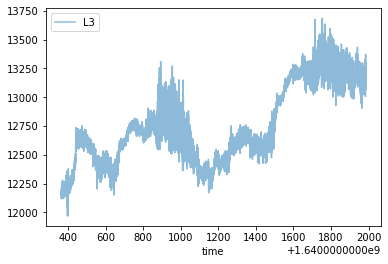

In [26]:
eeg_df.plot(y="L3", x="time", alpha=0.5)

## Preprocess (clean) the signals

Creating RawArray with float64 data, n_channels=16, n_times=202925
    Range : 0 ... 202924 =      0.000 ...  1623.392 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 62.49 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 62.50 Hz)
- Filter length: 41251 samples (330.008 sec)



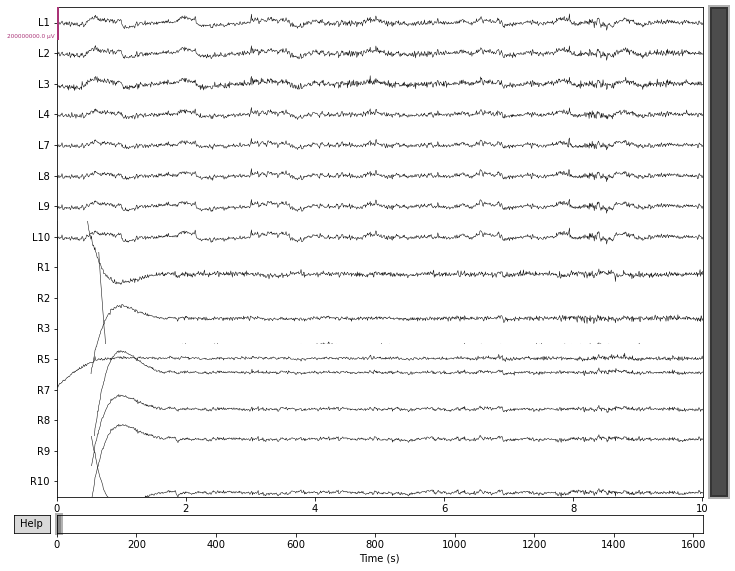

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 825 samples (6.600 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 62 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 62.49 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 62.50 Hz)
- Filter length: 41251 samples (330.008 sec)



C:\Users\LUKASS~1\AppData\Local\Temp/ipykernel_16060/2126812158.py:15: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw = raw.copy().set_montage(ceegrid_montage)


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 sec)

Executing RANSAC
This may take a while, so be patient...
Progress: 10%... 20%... 30%... 40%... 50%... 60%... 70%... 80%... 90%... 100%

RANSAC done!
Interpolating bad channels
    Automatic origin fit: head of radius 94.7 mm
Computing interpolation matrix from 12 sensor positions
Interpolating 4 sensors


C:\Users\LUKASS~1\AppData\Local\Temp/ipykernel_16060/2126812158.py:32: RuntimeWarning: Only 8 head digitization points of the specified kinds ("eeg", "extra",), fitting may be inaccurate
  raw = raw.interpolate_bads()


In [27]:
# %matplotlib qt

# Load EEG data into MNE Python for preprocessing
# Create MNE Python object
fs = 125 # Sampling frequency of the OpenBCI recording
ch_names = eeg_df.drop('time', axis=1).columns.values.tolist()
info = mne.create_info(ch_names, fs, ch_types='eeg')
raw = mne.io.RawArray(np.array(eeg_df.drop('time', axis = 1)).transpose(), info)

# High-Pass Filter & Plot for visual inspection
raw.copy().filter(l_freq = 1, h_freq = 62.49).plot(scalings=dict(eeg=100))

# Load custom montage (for cEEGrids) - these are the coordinates of the electrodes on the head
ceegrid_montage = mne.channels.read_custom_montage('ceegrid_sph.txt')
raw = raw.copy().set_montage(ceegrid_montage)

# Filter the data
raw = raw.notch_filter(freqs=(25, 50)) # Notch filter to remove power line noise
raw = raw.filter(l_freq = 1, h_freq = 62.49) # 1 Hz Highpass (detrend) & 62.5 Hz Lowpass (remove high-frequency artefacts)

# Detect (& interpolate) bad channels
# You can play around with this a bit if you like - it could also perform poorly in your experiment (the facial muscle artefacts are what you are interested in and should not necessarily be removed...)
raw.info['bads'] = []
nc = pyprep.NoisyChannels(raw, do_detrend=True, random_state=42)
nc.find_bad_by_SNR()
nc.find_bad_by_deviation()
nc.find_bad_by_hfnoise()
nc.find_bad_by_nan_flat()
nc.find_bad_by_ransac()
raw.info['bads'] = nc.get_bads()
# Interpolation can be done using mne python's interpolate_bads()
raw = raw.interpolate_bads()

## Cut the data

In [35]:
# Here you need to figure out now, how to extract the data per experiment condition/phase, 
# that you would like to extract features for; 
# Your goal is to get timestamps for when a part of the experiment started and when it ended.

# Some information that you might need here
# - You can use raw.get_data() to get to the cleaned signals and raw.times to get the now relative timestamps
# - You can also combine raw.get_data() with your original timestamps that you have in the .txt file


,0
0,0.000
1,0.008
2,0.016
3,0.024
4,0.032
...,...
202920,1623.360
202921,1623.368
202922,1623.376
202923,1623.384


## Feature extraction

In [10]:
# Here you have to first decide how to process the data. There are two initial options:
# - Extract features on moving windows (e.g. extract one feature per electrode 
#   for every 2s of the experiment phase or one per electrode for the entire experiment phase)


# You can see which features we have extraced in our NeuroIS article...

# Here is an example of how you could extract frequency band powers (requires a numpy array):
epoch_duration_sec = 2
psds, freqs = mne.time_frequency.psd_array_welch(array, fmin=1, fmax=62.5, n_fft=int(fs*epoch_duration_sec))
psds = 10. * np.log10(psds) # db normalization

psd_simple_welch_df = pd.DataFrame(psds.transpose(), columns=raw.ch_names)
psd_simple_welch_df['Frequency'] = freqs

def get_band_power(low_bound, high_bound):
    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low_bound, freqs <= high_bound)
    return psds[:, idx_band].mean(axis=1)

theta = get_band_power(4, 7)
alpha = get_band_power(8, 13)
beta = get_band_power(14, 30)

NameError: name 'array' is not defined

## Classifier Training

In [ ]:
# Here your ML magic comes in...